## <font color='blue'>Spark MLLib - Clustering - K-Means</font>

## Agrupando automóveis

In [1]:
# Imports
import math
import pandas as pd
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Spark Session - usada quando se trabalha com Dataframes no Spark
spSession = SparkSession.builder.master("local").appName("SparkMLLib").getOrCreate()

In [3]:
# Carregando os dados e gerando um RDD
carrosRDD = sc.textFile("data/carros2.csv")
carrosRDD.cache()

data/carros2.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [4]:
# Removendo a primeira linha do arquivo (cabeçalho)
primeiraLinha = carrosRDD.first()
carrosRDD2 = carrosRDD.filter(lambda x: x != primeiraLinha)
carrosRDD2.count()

197

In [5]:
carrosRDD2.take(5)

['subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389']

In [8]:
carrosRDD.take(5)

['MAKE,FUELTYPE,ASPIRE,DOORS,BODY,DRIVE,CYLINDERS,HP,RPM,MPG-CITY,MPG-HWY,PRICE',
 'subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348']

###### Verificando os dados Distintos de cada uma das colunas do RDD para realizar a limpeza dos dados

In [10]:
# Transforma o RDD sem cabeçalho em uma Lista
List_cars = carrosRDD2.map(lambda l: l.split(",")).collect()

In [11]:
# Transforma a lista criada em um Dataframe do Pandas, para melhor visualização dos dados
dfteste = pd.DataFrame(List_cars, columns=['MAKE','FUELTYPE','ASPIRE','DOORS','BODY','DRIVE','CYLINDERS','HP','RPM',
                                       'MPG_CITY','MPG_HWY','PRICE'])

In [12]:
# Retorna um Dictionary dos dados distintos onde a Key é o nome das colunas e o Values é um array de valores distintos
dictn={}
for colname in dfteste:
    dictn[colname]=dfteste[colname].unique()
dictn

{'MAKE': array(['subaru', 'chevrolet', 'mazda', 'toyota', 'mitsubishi', 'honda',
        'nissan', 'dodge', 'plymouth', 'isuzu', 'volkswagen', 'saab',
        'peugot', 'volvo', 'alfa-romero', 'audi', 'bmw', 'mercury',
        'porsche', 'mercedes-benz', 'jaguar'], dtype=object),
 'FUELTYPE': array(['gas', 'diesel'], dtype=object),
 'ASPIRE': array(['std', 'turbo'], dtype=object),
 'DOORS': array(['two', 'four'], dtype=object),
 'BODY': array(['hatchback', 'sedan', 'wagon', 'hardtop', 'convertible'],
       dtype=object),
 'DRIVE': array(['fwd', 'rwd', '4wd'], dtype=object),
 'CYLINDERS': array(['four', 'three', 'two', 'five', 'six', 'eight', 'twelve'],
       dtype=object),
 'HP': array(['69', '48', '68', '62', '60', '70', '58', '76', '78', '88', '73',
        '55', '82', '102', '52', '56', '86', '85', '116', '84', '92', '97',
        '112', '94', '90', '100', '101', '111', '110', '145', '114', '95',
        '152', '135', '156', '161', '154', '175', '160', '115', '142',
        '120',

# Limpeza dos Dados

In [96]:
# Convertendo e limpando os dados
def transformToNumeric( inputStr) :
    attList = inputStr.split(",")

    # FuelType
    fueltype = 1.0 if attList[1] == 'gas' else 0.0        

    # Aspire
    aspire = 1.0 if attList[2] == 'turbo' else 0.0
    
    # Doors
    doors = 2.0 if attList[3] == "two" else 4.0
    
    # Body
    if attList[4] == "sedan":
        body = 1.0
    elif attList[4] == 'hatchback':
        body = 2.0
    elif attList[4] == 'wagon':
        body = 3.0
    elif attList[4] == 'hardtop':
        body = 4.0
    elif attList[4] == 'convertible':
        body = 5.0
    else:
        body = 0.0
        
    # Cylinders
    if attList[6] == 'two':
        Cylinders = 2.0
    elif attList[6] == 'three':
        Cylinders = 3.0
    elif attList[6] == 'four':
        Cylinders = 4.0
    elif attList[6] == 'five':
        Cylinders = 5.0
    elif attList[6] == 'six':
        Cylinders = 6.0
    elif attList[6] == 'eight':
        Cylinders = 8.0
    elif attList[6] == 'twelve':
        Cylinders = 12.0
    else:
        Cylinders = 0.0
      
    linhas = Row(FUELTYPE = float(fueltype),
                 ASPIRE = float(aspire),
                 DOORS = doors, 
                 BODY = float(body), 
                 CYLINDERS = float(Cylinders),
                 HP = float(attList[7]), 
                 RPM = float(attList[8]),
                 MPG_CITY = float(attList[9]),
                 MPG_HWY = float(attList[10]),
                 PRICE = float(attList[11]),
                 MAKE = attList[0]
                )
    return linhas

In [97]:
# Aplicando a função
carrosRDD3 = carrosRDD2.map(transformToNumeric)
carrosRDD3.persist()
carrosRDD3.take(5)

[Row(ASPIRE=0.0, BODY=2.0, CYLINDERS=4.0, DOORS=2.0, FUELTYPE=1.0, HP=69.0, MAKE='subaru', MPG_CITY=31.0, MPG_HWY=36.0, PRICE=5118.0, RPM=4900.0),
 Row(ASPIRE=0.0, BODY=2.0, CYLINDERS=3.0, DOORS=2.0, FUELTYPE=1.0, HP=48.0, MAKE='chevrolet', MPG_CITY=47.0, MPG_HWY=53.0, PRICE=5151.0, RPM=5100.0),
 Row(ASPIRE=0.0, BODY=2.0, CYLINDERS=4.0, DOORS=2.0, FUELTYPE=1.0, HP=68.0, MAKE='mazda', MPG_CITY=30.0, MPG_HWY=31.0, PRICE=5195.0, RPM=5000.0),
 Row(ASPIRE=0.0, BODY=2.0, CYLINDERS=4.0, DOORS=2.0, FUELTYPE=1.0, HP=62.0, MAKE='toyota', MPG_CITY=35.0, MPG_HWY=39.0, PRICE=5348.0, RPM=4800.0),
 Row(ASPIRE=0.0, BODY=2.0, CYLINDERS=4.0, DOORS=2.0, FUELTYPE=1.0, HP=68.0, MAKE='mitsubishi', MPG_CITY=37.0, MPG_HWY=41.0, PRICE=5389.0, RPM=5500.0)]

In [98]:
# Criando um Dataframe do Spark
carrosDF = spSession.createDataFrame(carrosRDD3)
carrosDF.show()

+------+----+---------+-----+--------+----+----------+--------+-------+------+------+
|ASPIRE|BODY|CYLINDERS|DOORS|FUELTYPE|  HP|      MAKE|MPG_CITY|MPG_HWY| PRICE|   RPM|
+------+----+---------+-----+--------+----+----------+--------+-------+------+------+
|   0.0| 2.0|      4.0|  2.0|     1.0|69.0|    subaru|    31.0|   36.0|5118.0|4900.0|
|   0.0| 2.0|      3.0|  2.0|     1.0|48.0| chevrolet|    47.0|   53.0|5151.0|5100.0|
|   0.0| 2.0|      4.0|  2.0|     1.0|68.0|     mazda|    30.0|   31.0|5195.0|5000.0|
|   0.0| 2.0|      4.0|  2.0|     1.0|62.0|    toyota|    35.0|   39.0|5348.0|4800.0|
|   0.0| 2.0|      4.0|  2.0|     1.0|68.0|mitsubishi|    37.0|   41.0|5389.0|5500.0|
|   0.0| 2.0|      4.0|  2.0|     1.0|60.0|     honda|    38.0|   42.0|5399.0|5500.0|
|   0.0| 1.0|      4.0|  2.0|     1.0|69.0|    nissan|    31.0|   37.0|5499.0|5200.0|
|   0.0| 2.0|      4.0|  2.0|     1.0|68.0|     dodge|    37.0|   41.0|5572.0|5500.0|
|   0.0| 2.0|      4.0|  2.0|     1.0|68.0|  plymouth|

In [114]:
# Sumarizando os dados e extraindo a média e o desvio padrão

# Converte o resultado do Describe() para o Pandas para ser possível utilizar o método "iloc"
# Ignorando a Coluna MAKE
estats = carrosDF.select("ASPIRE","BODY", "CYLINDERS","DOORS","FUELTYPE","HP","MPG_CITY","MPG_HWY","PRICE","RPM").describe().toPandas()
estats

,summary,ASPIRE,BODY,CYLINDERS,DOORS,FUELTYPE,HP,MPG_CITY,MPG_HWY,PRICE,RPM
0,count,197,197,197,197,197,197,197,197,197,197
1,mean,0.17766497461928935,1.8274111675126903,4.370558375634518,3.1370558375634516,0.9035532994923858,103.60406091370558,25.15228426395939,30.629441624365484,13279.644670050762,5118.0203045685275
2,stddev,0.3832043061430227,1.0003366262378968,1.068923830782004,0.9930870555633499,0.29595498046323965,37.639205349518356,6.437862917085915,6.836258837310616,8010.334218462036,481.03591405011446
3,min,0.0,1.0,2.0,2.0,0.0,48.0,13.0,16.0,5118.0,4150.0
4,max,1.0,5.0,12.0,4.0,1.0,262.0,49.0,54.0,45400.0,6600.0


In [115]:
# Coletando a Média e o Desvio Padrão
medias = estats.iloc[1,1:11].values.tolist() # [1,1:11] -> Linha de index 1, Colunas de Index 1 até 10
desvios = estats.iloc[2,1:11].values.tolist()

In [ ]:
medias

In [ ]:
desvios

In [54]:
# Colocando a média e o desvio padrão e variáves do tipo Broadcast
# Todas maquinas do cluster consegue acessar as variáveis broadcasts
bc_media = sc.broadcast(medias)
bc_desvio = sc.broadcast(desvios)

In [55]:
# Função para centralizar e aplicar escala aos dados. Cada valor será subtraído da média então dividido pelo desvio padrão
def centerAndScale(inRow) :
    global bc_media
    global bc_desvio
    
    meanArray = bc_media.value
    stdArray = bc_desvio.value

    retArray = []
    
    for i in range(len(meanArray)):
        retArray.append( (float(inRow[i]) - float(meanArray[i])) / float(stdArray[i]) )
    return Vectors.dense(retArray)

In [116]:
carrosRDD4 = carrosDF.select("ASPIRE","BODY", "CYLINDERS","DOORS","FUELTYPE","HP","MPG_CITY","MPG_HWY","PRICE","RPM").rdd.map(centerAndScale)
carrosRDD4.collect()

[DenseVector([-0.4636, 0.1725, -0.3467, -1.145, 0.3259, -0.9194, 0.9083, 0.7856, -1.0189, -0.4532]),
 DenseVector([-0.4636, 0.1725, -1.2822, -1.145, 0.3259, -1.4773, 3.3936, 3.2723, -1.0148, -0.0375]),
 DenseVector([-0.4636, 0.1725, -0.3467, -1.145, 0.3259, -0.9459, 0.753, 0.0542, -1.0093, -0.2453]),
 DenseVector([-0.4636, 0.1725, -0.3467, -1.145, 0.3259, -1.1053, 1.5297, 1.2244, -0.9902, -0.6611]),
 DenseVector([-0.4636, 0.1725, -0.3467, -1.145, 0.3259, -0.9459, 1.8403, 1.517, -0.9851, 0.7941]),
 DenseVector([-0.4636, 0.1725, -0.3467, -1.145, 0.3259, -1.1585, 1.9956, 1.6633, -0.9838, 0.7941]),
 DenseVector([-0.4636, -0.8271, -0.3467, -1.145, 0.3259, -0.9194, 0.9083, 0.9319, -0.9713, 0.1704]),
 DenseVector([-0.4636, 0.1725, -0.3467, -1.145, 0.3259, -0.9459, 1.8403, 1.517, -0.9622, 0.7941]),
 DenseVector([-0.4636, 0.1725, -0.3467, -1.145, 0.3259, -0.9459, 1.8403, 1.517, -0.9622, 0.7941]),
 DenseVector([-0.4636, 0.1725, -0.3467, -1.145, 0.3259, -0.9459, 0.9083, 1.0782, -0.8969, -0.2453])

In [118]:
# Criando um Dataframe
carrosRDD5 = carrosRDD4.map( lambda f:Row(features = f))
carrosDF2 = spSession.createDataFrame(carrosRDD5)
carrosDF2.show(10, truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-0.46362990125945963,0.17253075410863264,-0.346664902552902,-1.1449709581789205,0.3258830121954773,-0.9193621542317812,0.908331819324846,0.7855990393932032,-1.0188894055431532,-0.4532308258085988]   |
|[-0.46362990125945963,0.17253075410863264,-1.282185256017582,-1.1449709581789205,0.3258830121954773,-1.477291042607442,3.3936286027553275,3.272339287907228,-1.0147697272500873,-0.03746145

In [119]:
# Criando o modelo
# k -> # de grupos/cluster
kmeans = KMeans(k = 3, seed = 1)
modelo = kmeans.fit(carrosDF2)

In [120]:
# Previsões
previsoes = modelo.transform(carrosDF2)
previsoes.show(truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|features                                                                                                                                                                                                |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|[-0.46362990125945963,0.17253075410863264,-0.346664902552902,-1.1449709581789205,0.3258830121954773,-0.9193621542317812,0.908331819324846,0.7855990393932032,-1.0188894055431532,-0.4532308258085988]   |1         |
|[-0.46362990125945963,0.17253075410863264,-1.282185256017582,-1.1449709581789205,0.3258830121954773,-1.477291042607442,3.3936286027553275,3.272

In [121]:
def unstripData(instr) :
    return (instr["prediction"], instr["features"][0], instr["features"][1], instr["features"][2], instr["features"][3],
           instr["features"][4], instr["features"][5], instr["features"][6], instr["features"][7], instr["features"][8],
           instr["features"][9])

In [145]:
carrosRDD6 = previsoes.rdd.map(unstripData)
predList = carrosRDD6.collect()
predPd = pd.DataFrame(predList)

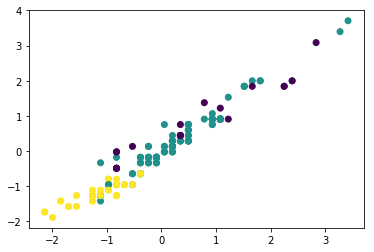

In [144]:
# Gráfico com o resultados dos clusters criados analisando 2 variáveis
plt.cla()
plt.scatter(predPd[8], predPd[7],  c = predPd[0])

In [146]:
# Combinando o resultado do agrupamento com o RDD original,
# para ser possível identificar quais tipos de veículos foram classificados nos mesmos grupos
carrosRDD7 = carrosRDD6.map(lambda i: float(i[0]))

carrosRDD2.zip(carrosRDD7).collect()
#carrosRDD6.collect()

[('subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118', 1.0),
 ('chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151', 1.0),
 ('mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195', 1.0),
 ('toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348', 1.0),
 ('mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389', 1.0),
 ('honda,gas,std,two,hatchback,fwd,four,60,5500,38,42,5399', 1.0),
 ('nissan,gas,std,two,sedan,fwd,four,69,5200,31,37,5499', 1.0),
 ('dodge,gas,std,two,hatchback,fwd,four,68,5500,37,41,5572', 1.0),
 ('plymouth,gas,std,two,hatchback,fwd,four,68,5500,37,41,5572', 1.0),
 ('mazda,gas,std,two,hatchback,fwd,four,68,5000,31,38,6095', 1.0),
 ('mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,31,38,6189', 1.0),
 ('dodge,gas,std,four,hatchback,fwd,four,68,5500,31,38,6229', 1.0),
 ('plymouth,gas,std,four,hatchback,fwd,four,68,5500,31,38,6229', 1.0),
 ('chevrolet,gas,std,two,hatchback,fwd,four,70,5400,38,43,6295', 1.0),
 ('toyota,gas,std,two,hatchback,fwd,